In [63]:
library('readr')
fname <- 'spei_input_files/Met_all_gapfill.csv'
df <- read_csv(fname)
df$Jul_Day <- 0 # string, get rid of it
tail(df)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  Date = col_character(),
  Month = col_integer(),
  Day = col_integer(),
  Year = col_integer(),
  Sta = col_integer(),
  Jul_Day = col_character()
)
See spec(...) for full column specifications.


X1,Date,Month,Day,Year,Sta,Avg_Temp,Max_Temp,Min_Temp,Avg_RH,⋯,Avg_Resultant_WindSP,Avg_Wind_Dir,Solar_Rad,Avg_Soil_Temp,Max_Soil_Temp,Min_Soil_Temp,Jul_Day,Max_Tempfill,Min_Tempfill,Avg_Tempfill
84040,9/25/2015,9,25,2015,50,22.3,30.2,14.4,40.4,⋯,2.1,93.2,25.2,25.3,31.7,20.1,0,30.2,14.4,22.3
84041,9/26/2015,9,26,2015,50,22.0,31.0,13.1,33.1,⋯,1.5,182.2,25.2,26.0,32.1,20.9,0,31.0,13.1,22.0
84042,9/27/2015,9,27,2015,50,23.9,33.9,13.9,25.2,⋯,0.8,26.1,25.3,26.1,31.7,21.3,0,33.9,13.9,23.9
84043,9/28/2015,9,28,2015,50,24.6,33.4,15.8,21.9,⋯,1.9,16.9,24.9,25.9,31.8,20.7,0,33.4,15.8,24.6
84044,9/29/2015,9,29,2015,50,24.1,33.6,14.6,23.8,⋯,1.7,94.3,24.3,26.2,32.3,20.8,0,33.6,14.6,24.1
84045,9/30/2015,9,30,2015,50,26.0,31.9,20.2,28.9,⋯,4.8,162.0,22.2,27.1,31.8,23.4,0,31.9,20.2,26.0


In [36]:
colnames(df)


[1] "X1"                   "Date"                 "Month"               
 [4] "Day"                  "Year"                 "Sta"                 
 [7] "Avg_Temp"             "Max_Temp"             "Min_Temp"            
[10] "Avg_RH"               "Precip"               "Avg_VP"              
[13] "Avg_Wind_SP"          "Avg_Resultant_WindSP" "Avg_Wind_Dir"        
[16] "Solar_Rad"            "Avg_Soil_Temp"        "Max_Soil_Temp"       
[19] "Min_Soil_Temp"        "Jul_Day"              "Max_Tempfill"        
[22] "Min_Tempfill"         "Avg_Tempfill"

           station_40
1988-01-31         NA
1988-02-29         NA
1988-03-31  0.6749155
1988-04-30  1.4883211
1988-05-31  1.8719084
1988-06-30  1.8595647


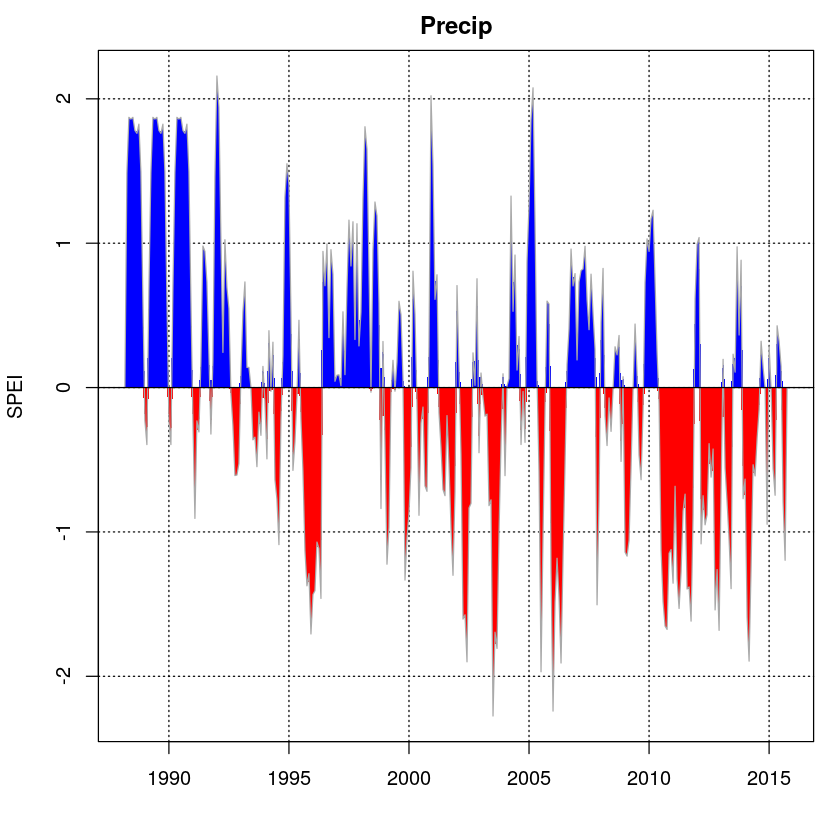

           station_42
1989-02-28         NA
1989-03-31         NA
1989-04-30  0.7430239
1989-05-31  1.7595586
1989-06-30  1.8629244
1989-07-31  1.8941505


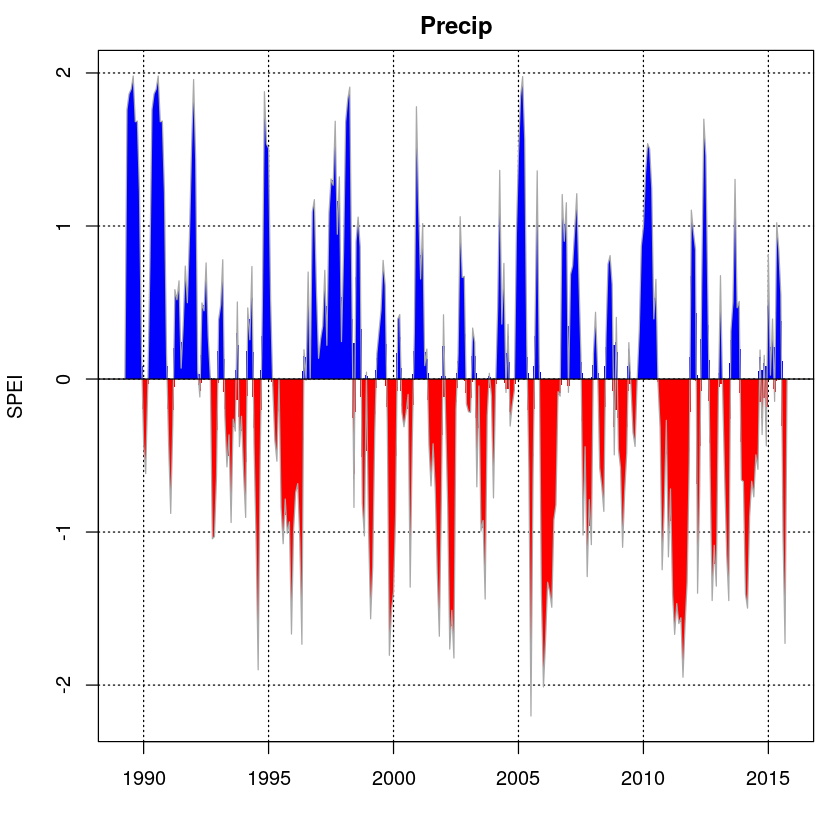

            station_49
1999-01-31          NA
1999-02-28          NA
1999-03-31 -1.03563836
1999-04-30 -0.01930295
1999-05-31  0.46792877
1999-06-30  0.50865557


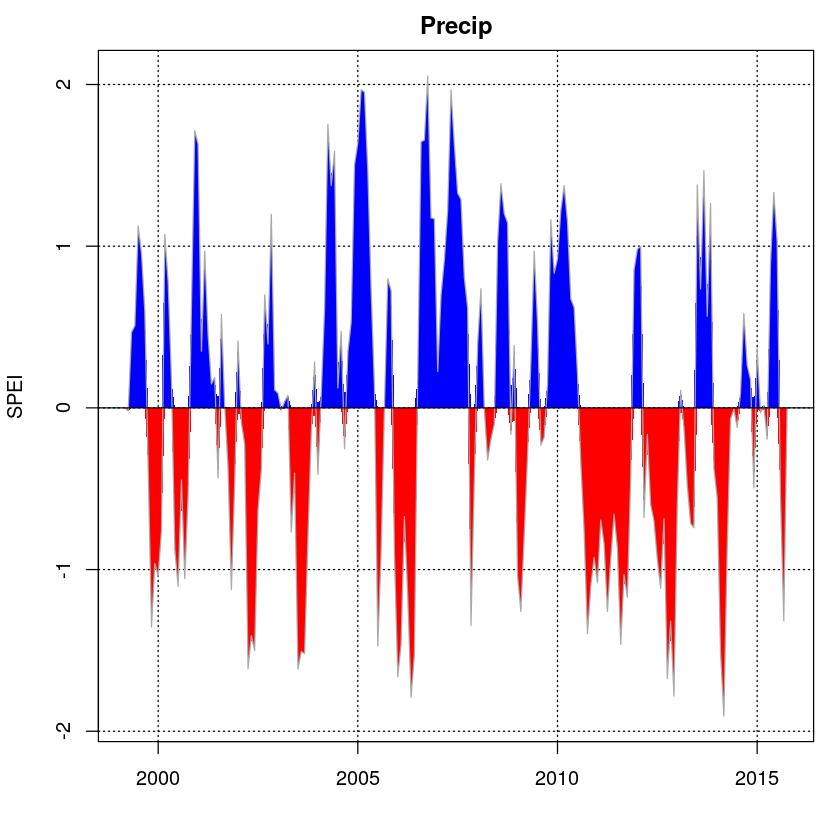

           station_50
2002-01-31         NA
2002-02-28         NA
2002-03-31 -0.6238148
2002-04-30 -1.3548315
2002-05-31 -1.3978925
2002-06-30 -1.4671964


[1] 334

[1] 333

[1] 322
[1] 322


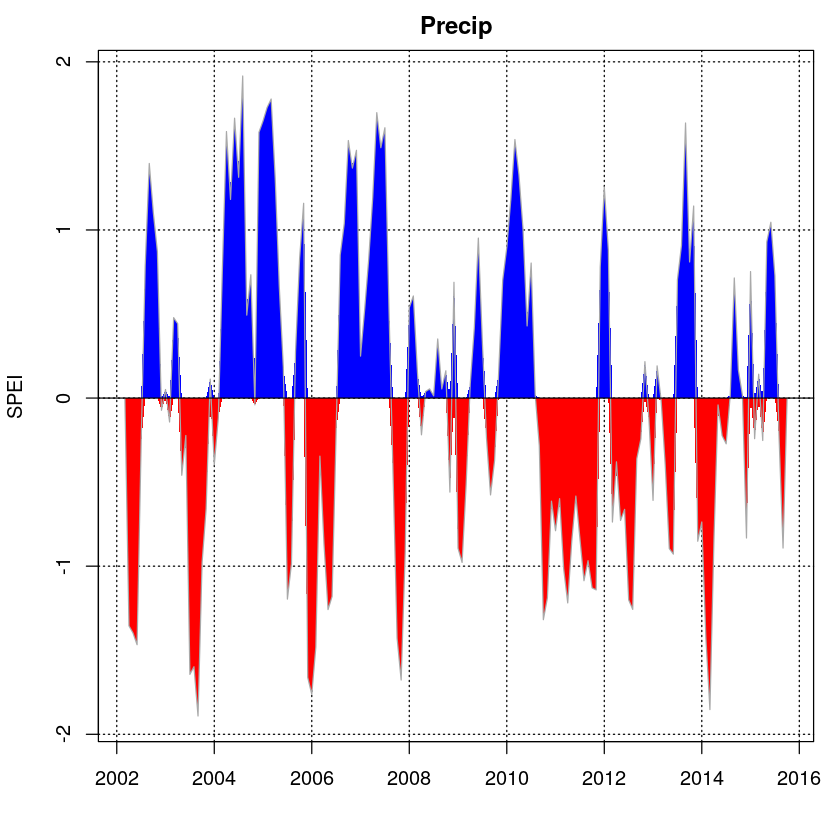

In [68]:
library('SPEI')
library('xts')

# Check if there is a plateau in SPEI for some reason around 2007

# Integration period for SPEI (in months)
int_months <- 3
# First part of outfile
outfile <- paste("SPEI_", as.character(int_months), "mo_Sev", sep='')

station <- c(40, 42, 49, 50)
lat <- c(34.3592, 34.368, 34.3331, 34.3348)

for (i in 1:4){
    df_sta <- subset(df, subset=Sta==station[i])
    
    # Old way for PET: df_sta$PET <- thornthwaite(df_sta$Avg_Temp, lat[i], na.rm=T)

    # Make a timeseries and get starting year and month
    df_xts <- xts(df_sta[,3:ncol(df_sta)], order.by=as.Date(df_sta$Date, "%m/%d/%Y"))
    startmon <- as.numeric(as.yearmon(index(df_xts[1])))
    startyr <- floor(startmon)
    startmon <- ceiling((startmon-startyr)*12) + 1
    
    PET <- thornthwaite(apply.monthly(df_xts$Avg_Temp, FUN=mean), lat[i], na.rm=T)
    PET <- xts(as.vector(PET),  order.by=index(apply.monthly(df_xts$Avg_Temp, FUN=sum)))
    # Penman works too but produces lots of NA values
    #PET_penman <- penman(apply.monthly(df_xts$Min_Temp, FUN=mean), apply.monthly(df_xts$Max_Temp, FUN=mean),
    #                     apply.monthly(df_xts$Avg_Wind_SP, FUN=mean), Rs=apply.monthly(df_xts$Solar_Rad, FUN=mean),
    #                     RH=apply.monthly(df_xts$Avg_RH, FUN=mean), lat=lat[i], z=1600, na.rm=T)
    # Calculate climatic water difference and then SPEI
    # old way: cwdiff <- apply.monthly(df_xts$Precip, FUN=sum) - apply.monthly(df_xts$PET, FUN=sum)
    cwdiff <- apply.monthly(df_xts$Precip, FUN=sum) - PET
    #cwdiff_penman <- apply.monthly(df_xts$Precip, FUN=sum) - PET_penman

    spei_sta <- spei(ts(cwdiff, frequency=12, start=c(startyr, startmon)), int_months, na.rm=TRUE)
    #spei_sta_penman <- spei(ts(cwdiff_penman, frequency=12, start=c(startyr, startmon)), int_months, na.rm=TRUE)
    
    plot(spei_sta)
    #plot(spei_sta_penman)
    
    spei_sta <- xts(as.vector(spei_sta$fitted),  index(cwdiff))
    colnames(spei_sta) <- paste('station_', as.character(station[i]), sep='')
    # 
    print(head(spei_sta))
    if (i==1){
        df_new <- spei_sta
    } else if (i > 1) {
        df_new <- cbind(df_new, spei_sta)
    }
}

# Somehow a funky entry at 2009-2-12 is created, remove
# This only happens for station 50
nrow(df_new)
df_new <- df_new[c('::2009-01-31', '2009-02-28::')]
nrow(df_new)

# There may be both infinite and NA values in the output
# Convert -Inf to NA
print(sum(is.na(df_new)))
df_new[!is.finite(df_new)] <- NA
print(sum(is.na(df_new)))

#print(tail(df_new))
write.zoo(df_new, file = paste('./SPEI_out/', outfile, '.csv', sep=''),
          index.name = "Date", sep=',', row.names = FALSE, col.names=TRUE)

# Interpolate over NA values
df_new <- na.approx(df_new)

write.zoo(df_new, file = paste('./SPEI_out/', outfile, '_NAinterp.csv', sep=''),
          index.name = "Date", sep=',', row.names = FALSE, col.names=TRUE)
